In [1]:
import pandas as pd
import numpy as np

# Visualization (optional but useful)
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy.stats import ttest_ind, chi2_contingency, ks_2samp

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
df = pd.read_csv(r"Dataset\WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
df.describe().T
df.select_dtypes(include=["int64", "float64"]).skew()


SeniorCitizen     1.833633
tenure            0.239540
MonthlyCharges   -0.220524
dtype: float64

In [4]:
df.drop(columns=["customerID"], inplace=True)


In [5]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


C:\Users\HP\AppData\Local\Temp\ipykernel_14660\61331631.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)


In [6]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})


In [7]:
df.groupby("Churn")[["tenure", "MonthlyCharges", "TotalCharges"]].mean()
df.groupby("Churn")[["tenure", "MonthlyCharges", "TotalCharges"]].median()


,tenure,MonthlyCharges,TotalCharges
Churn,,,
0,38.0,64.425,1679.525
1,10.0,79.650,703.550


In [8]:
pd.crosstab(df["Contract"], df["Churn"], normalize="index")
pd.crosstab(df["PaymentMethod"], df["Churn"], normalize="index")


Churn,0,1
PaymentMethod,,
Bank transfer (automatic),0.832902,0.167098
Credit card (automatic),0.847569,0.152431
Electronic check,0.547146,0.452854
Mailed check,0.808933,0.191067


In [9]:
def chi_square_test(feature):
    table = pd.crosstab(df[feature], df["Churn"])
    chi2, p, dof, exp = chi2_contingency(table)
    print(f"{feature} | p-value: {p:.5f}")

for col in ["Contract", "PaymentMethod", "InternetService"]:
    chi_square_test(col)

chi2, p, _, _ = chi2_contingency(pd.crosstab(df["Contract"], df["Churn"]))
print(p)


Contract | p-value: 0.00000
PaymentMethod | p-value: 0.00000
InternetService | p-value: 0.00000
5.863038300673391e-258


In [10]:
num_cols = df.select_dtypes(include=["int64", "float64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns


In [11]:
before_features = df.shape[1]

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

after_features = df.shape[1]

before_features, after_features


(20, 31)

In [12]:
scaler = StandardScaler()
num_cols = num_cols.drop("Churn")   # VERY IMPORTANT
df[num_cols] = scaler.fit_transform(df[num_cols])
df["Churn"] = df["Churn"].astype(int)



In [13]:
df.corr()["Churn"].sort_values(ascending=False).head(10)


Churn                             1.000000
InternetService_Fiber optic       0.308020
PaymentMethod_Electronic check    0.301919
MonthlyCharges                    0.193356
PaperlessBilling_Yes              0.191825
SeniorCitizen                     0.150889
StreamingTV_Yes                   0.063228
StreamingMovies_Yes               0.061382
MultipleLines_Yes                 0.040102
PhoneService_Yes                  0.011942
Name: Churn, dtype: float64

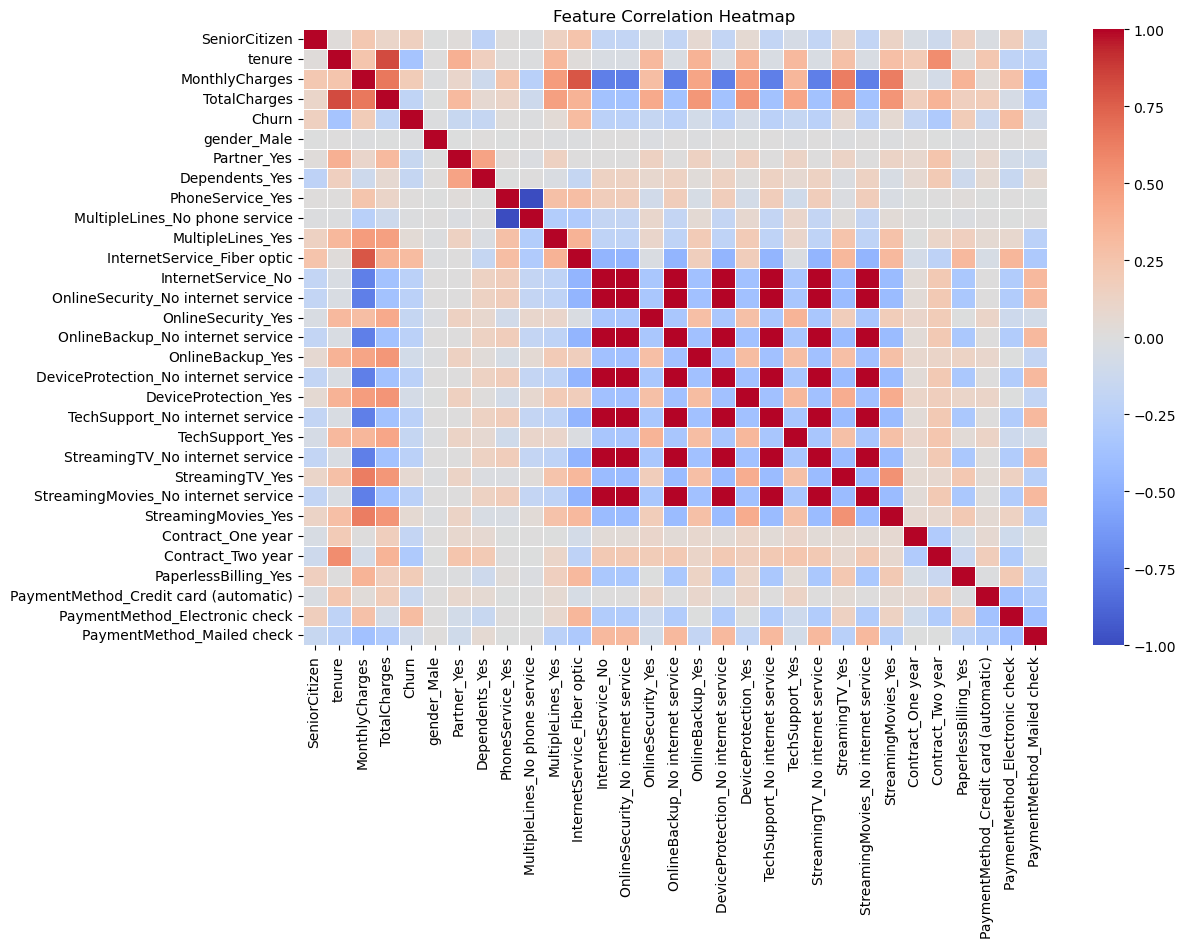

In [14]:
plt.figure(figsize=(12, 8))
corr = df.corr()

sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)

plt.title("Feature Correlation Heatmap")
plt.show()


In [15]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts(normalize=True))

print("\nAfter SMOTE:")
print(y_train_smote.value_counts(normalize=True))




Before SMOTE:
Churn
0    0.734647
1    0.265353
Name: proportion, dtype: float64

After SMOTE:
Churn
0    0.5
1    0.5
Name: proportion, dtype: float64


In [17]:
print("===== CLASS DISTRIBUTION =====")
print("Before SMOTE (Training set):")
print(y_train.value_counts())
print("\nTotal samples before SMOTE:", y_train.shape[0])

print("\nAfter SMOTE (Training set):")
print(y_train_smote.value_counts())
print("\nTotal samples after SMOTE:", y_train_smote.shape[0])


===== CLASS DISTRIBUTION =====
Before SMOTE (Training set):
Churn
0    4139
1    1495
Name: count, dtype: int64

Total samples before SMOTE: 5634

After SMOTE (Training set):
Churn
0    4139
1    4139
Name: count, dtype: int64

Total samples after SMOTE: 8278


In [18]:
train_preprocessed = pd.concat([X_train_smote, y_train_smote], axis=1)
test_preprocessed = pd.concat([X_test, y_test], axis=1)

train_preprocessed.to_csv("train_preprocessed.csv", index=False)
test_preprocessed.to_csv("test_preprocessed.csv", index=False)


### VISUALIZATION

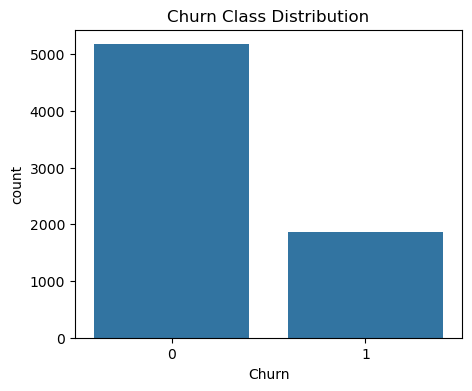

In [19]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Class Distribution")
plt.show()


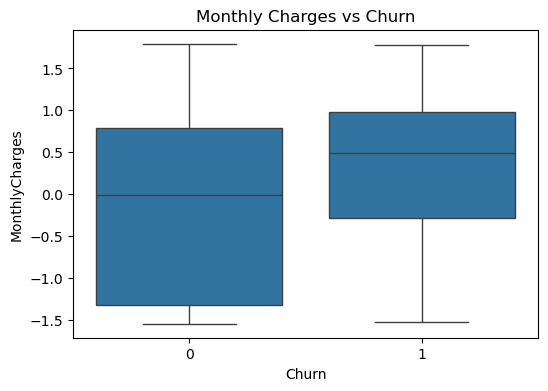

In [20]:
plt.figure(figsize=(6, 4))
sns.boxplot(x="Churn", y="MonthlyCharges", data=df)
plt.title("Monthly Charges vs Churn")
plt.show()


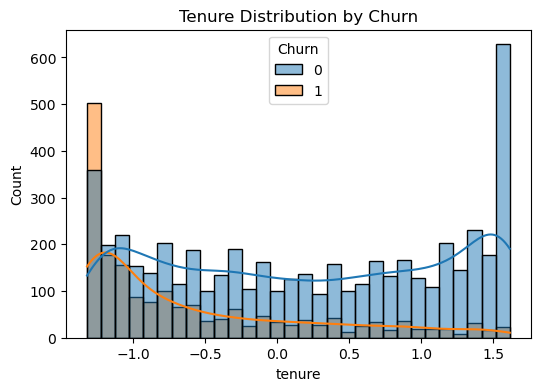

In [21]:
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x="tenure", hue="Churn", bins=30, kde=True)
plt.title("Tenure Distribution by Churn")
plt.show()


In [22]:
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    class_weight="balanced",
    random_state=42
)

rf.fit(X_train_smote, y_train_smote)


RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=10, n_estimators=200, random_state=42)

In [23]:
y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1035
           1       0.53      0.72      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.75      0.76      1409



In [24]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

print("===== MODEL METRICS =====")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))

print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))


===== MODEL METRICS =====
Accuracy : 0.7544357700496807
Precision: 0.52734375
Recall   : 0.7219251336898396
F1 Score : 0.6094808126410836

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      1035
           1       0.53      0.72      0.61       374

    accuracy                           0.75      1409
   macro avg       0.71      0.74      0.72      1409
weighted avg       0.79      0.75      0.76      1409



In [25]:
confusion_matrix(y_test, y_pred)


array([[793, 242],
       [104, 270]], dtype=int64)

Confusion Matrix (Raw):
[[793 242]
 [104 270]]


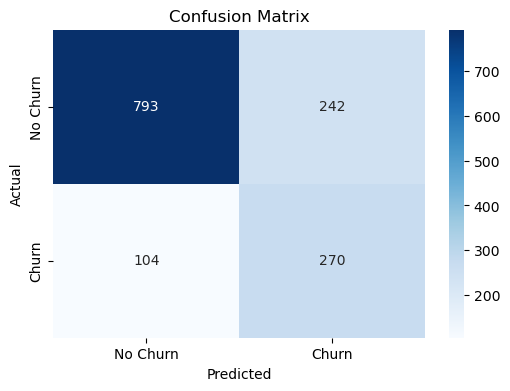

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix (Raw):")
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [27]:
feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


tenure                            0.172822
TotalCharges                      0.138165
MonthlyCharges                    0.098882
Contract_Two year                 0.088636
PaymentMethod_Electronic check    0.084682
InternetService_Fiber optic       0.068357
PaperlessBilling_Yes              0.045069
Contract_One year                 0.034314
OnlineSecurity_Yes                0.020320
TechSupport_Yes                   0.018387
dtype: float64

In [28]:
feature_importance.describe()


count    30.000000
mean      0.033333
std       0.042316
min       0.004629
25%       0.011161
50%       0.013563
75%       0.030816
max       0.172822
dtype: float64

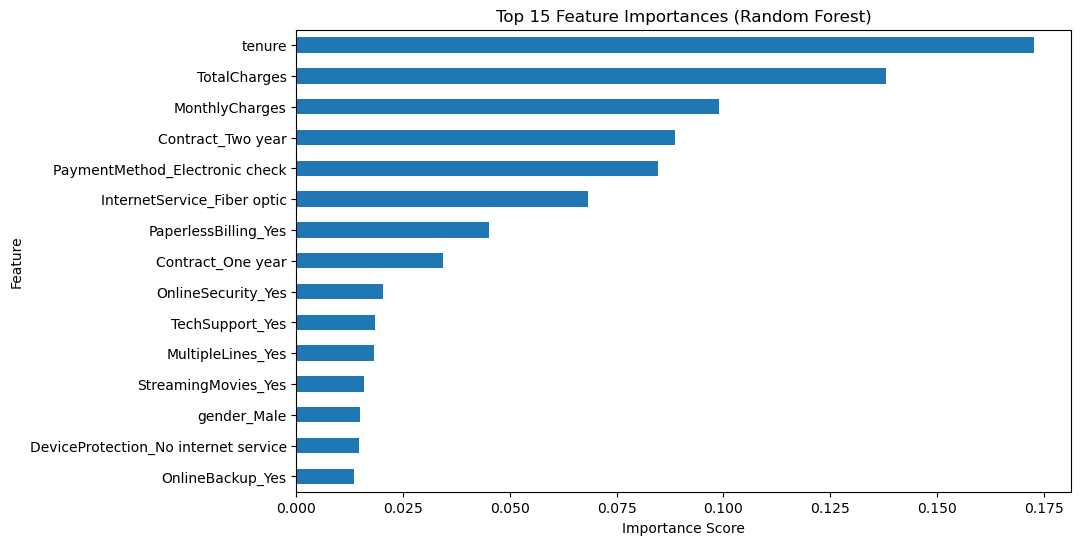

In [29]:
import matplotlib.pyplot as plt

feature_importance = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

top_features = feature_importance.head(15)

plt.figure(figsize=(10, 6))
top_features.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()
